<a href="https://colab.research.google.com/github/francescomontagna/Quantum-Reinforcement-Learning/blob/main/QuantumRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google QuantumAI

## Install

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq
    print("installed cirq.")

## Imports

In [2]:
import cirq
from cirq import Simulator

# Imports

In [3]:
import time
import math
import cmath
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from functools import reduce

# Introduction
## Problems
- Since we can access the features, and know the transition probability from a state to another, this RL protocol is model based.
Note that this is in contrast with the uncertainty about a quantum state from the observator point of view: an observator can only access the collapsed state, having no access to the amplitudes. 

In the paper Girolami sent me, they explicitly account for this fact, setting up a model free protocol.  


## Reward
Il principale problema è la formulzione della reward. per ora, l'unica soluzione tale da portare risultati accettabili è stata:
- reward = "grande" per stato terminal
- reward < 0 per stato non terminal  

L'aggiunta di reward negativa a punire ogni step che non portasse a uno stato terminale, è stato cruciale. Infatti, ho usato altri tipi di reward, ma tutte fallimentari  
- fidelity
- fidelity per stato terminale, altrimenti 0
- "grande" per stato terminale, altrimenti 0  

Tutti questi tentativi si sono mostrati fallimentari

## Off Policy
Sono dovuto ricorrere a un'approccio off policy, in quanto un approccio on policy non garantiva esplorazione sufficiente in uno spazio di ricerca così vasto. I risultati erano frtemente limitati, la matrice dei weight non vedeva mai alcune azioni, il cui valore rimaneva 0 per ogni features. I risultati erano in media peggiori di un' approccio Random.  
Andando a usare una bahaviour policy completamente randomica, e una target policy completamente greedy, i risultati sono notavolmente migliorati. 

# Quantum Setup

### Qubit

In [4]:
class Qubit:
  def __init__(self, amplitudes):
    """
    Args:
      amplitudes (np.array): amplitudes of the |0>, |1> vectors
    """
    error = "Error: sum of squared amplitudes must be = 1"
    assert math.isclose(reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, amplitudes)), 1, rel_tol = 1e-2), error
    self._amplitudes = amplitudes

  def qubit(self):
    return self._amplitudes
    

class Basis(Qubit):
  def __init__(self, index):
    """
    Args:
      index: index of the position = 1
    """
    amplitudes = np.zeros((2, ))
    amplitudes[index] += 1
    super().__init__(amplitudes)

### Quantum State

In [5]:
class QuantumState:
  def __init__(self, amplitudes): 

    # We assume computational basis
    self._basis = {
        '00': [Basis(0), Basis(0)],
        '01': [Basis(0), Basis(1)],
        '10': [Basis(1), Basis(0)],
        '11': [Basis(1), Basis(1)],
    }

    a1, a2, a3, a4 = amplitudes
    self._amplitudes = {
        '00': a1,
        '01': a2,
        '10': a3,
        '11': a4
    }
    
    self._keys = list(self._basis.keys())

    error = "Error: sum of squared amplitudes must be = 1"
    val = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, amplitudes))
    assert math.isclose(val, 1, rel_tol = 1e-2), error + f" instead is {val}"

  def get_amplitudes(self):
    return np.array(list(self._amplitudes.values()))

  def get_features(self):
    real = np.real(list(self._amplitudes.values()))
    imag = np.imag(list(self._amplitudes.values()))
    return np.concatenate((real, imag))

  def apply_gate(self, gate, inplace = False):
    updated_amplitudes = gate.apply(self)
    if inplace:
      self._amplitudes = updated_amplitudes
      return None

    return QuantumState(list(updated_amplitudes.values()))

  def fidelity_score(self, other):
    # TODO: check on nielsen
    # This implementation is from paper
    """
    Args:
      other (QuantumState): measure the fidelity between self and another quantum state
    Return:
      fidelity (float): fidelity score between [0, 1]
    """
    # Inner product can be computed in terms of matrix representation. Page 67 Nielsen-Chuang
    return np.square(abs(np.matmul(np.conj(self.get_amplitudes()), other.get_amplitudes())))

### Quantum Gates

In [6]:
class QuantumGate:
  def __init__(self, name, unitary, target):
    """
    Args: 
      unitary: 2x2 unitary operator
      target: 0 or 1 to denote the qubit the matrix is acting on
    """
    self._name = name
    self._U = unitary.flatten()
    self._target = target


  def apply(self, quantum_state):
    """
    Args:
      quantum_state (QuantumState): quantum state to which apply the quantum operator
    Return:
      updated (dict): didctionary with updated amplitudes
    """
    # Directly implement update rule on the amplitudes for a 2 qubits case. 
    # NOTE: This approach is not scalable! Refine or use qiskit for more than 2 qubits
    a_00, a_01, a_10, a_11 = quantum_state.get_amplitudes()
    updated = dict()

    if self._target == 0:
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_10
      updated['01'] = self._U[0]*a_01 + self._U[1]*a_11
      updated['10'] = self._U[2]*a_00 + self._U[3]*a_10
      updated['11'] = self._U[2]*a_01 + self._U[3]*a_11

    else:
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_01
      updated['01'] = self._U[2]*a_00 + self._U[3]*a_01
      updated['10'] = self._U[0]*a_10 + self._U[1]*a_11
      updated['11'] = self._U[2]*a_10 + self._U[3]*a_11

    # Check if amplitudes still satisfy condition
    normalization = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, updated.values()))
    error = f"Error: sum of squared amplitudes must be = 1.\n Amplitudes: {list(updated.values())}, summing up to {normalization}"
    assert math.isclose(normalization, 1, rel_tol = 1e-2), error
    
    return updated


class CNOT(QuantumGate):
  def __init__(self, control):
    """
    Args:
      control (int): if 0, first qubit is the control, else second
    Return:
      result (QuantumState): quantum state with amplitudes modified
    """
    self._control = control
    super().__init__('cnot', np.array([[0, 1], [1, 0]]), 1-control)


  def apply(self, quantum_state):
    """
    Args:
      state (QuantumState): quantum state to which apply the quantum operator
    Return:
      result (QuantumState): quantum state with amplitudes modified
    """
    # Directly implement update rule on the amplitudes for a 2 qubits case. 
    # NOTE: This approach is not scalable! Refine or use qiskit for more than 2 qubits
    a_00, a_01, a_10, a_11 = quantum_state.get_amplitudes()
    updated = dict()

    if self._control == 0: # Then target = 2nd: if 1st qubit == 1, flip 2nd qubit.
      updated['00'] = a_00
      updated['01'] = a_01
      updated['10'] = self._U[0]*a_10 + self._U[1]*a_11
      updated['11'] = self._U[2]*a_10 + self._U[3]*a_11

    if self._control == 1: # Then control = 1st: if 2nd qubit == 1, flip 1st qubit.
      updated['00'] = self._U[0]*a_00 + self._U[1]*a_10
      updated['01'] = self._U[0]*a_01 + self._U[1]*a_11
      updated['10'] = a_10
      updated['11'] = a_11

    # Check if amplitudes still satisfy condition
    normalization = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, updated.values()))
    error = f"Error: sum of squared amplitudes must be = 1.\n Amplitudes: {list(updated.values())}, summing up to {normalization}"
    assert math.isclose(normalization, 1, rel_tol = 1e-2), error
    
    return updated

### Gates List

In [7]:
class Gates:
  def __init__(self):
    gates = dict()
    self._num_gates = 0

    # Useful
    targets = [0, 1]
    j = 1j # complex unit

    ########### CNOT ###########
    gates['CNOT'] = CNOT(control = 0)
    self._num_gates += 1

    ########### Rotations ###########
    angles_names = ['pi', '2pi/3', 'pi/2', 'pi/3', 'pi/4']
    angles_values = (math.pi / 2) * np.array([1, 2/3, 1/2, 1/3, 1/4])
    angles = {k:v for k,v in zip(angles_names, angles_values)}

    # Rx
    for name, theta in angles.items():
      for t in targets:
        key = 'Rx' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[math.cos(theta), -j*math.sin(theta)],
                                                      [-j*math.sin(theta), math.cos(theta)]]), t)
        self._num_gates += 1
        
    # Ry
    for name, theta in angles.items():
      for t in targets:
        key = 'Ry' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[math.cos(theta), -math.sin(theta)],
                                                      [math.sin(theta), math.cos(theta)]]), t)
        self._num_gates += 1

    # Rz
    for name, theta in angles.items():
      for t in targets:
        key = 'Rz' + str(t) + '(' + name + ')'
        gates[key] = QuantumGate(key, np.array([[cmath.exp(-j*theta), 0],
                                                      [0, cmath.exp(j*theta)]]), t)
        self._num_gates += 1

    self._keys = list(gates.keys())
    self._gates = list(gates.values())

  def num_gates(self):
    return self._num_gates

#### Google Gates

In [8]:
class GoogleGates: 
  def __init__(self, keys = list()):
    PI = math.pi
    self._keys = keys
    self._gates = [
                  (cirq.CNOT, None),
                  (cirq.rx(PI), cirq.I),
                  (cirq.I, cirq.rx(PI)),
                  (cirq.rx(2*PI/3), cirq.I),
                  (cirq.I, cirq.rx(2*PI/3)),
                  (cirq.rx(PI/2), cirq.I),
                  (cirq.I, cirq.rx(PI/2)),
                  (cirq.rx(PI/3), cirq.I),
                  (cirq.I, cirq.rx(PI/3)),
                  (cirq.rx(PI/4), cirq.I),
                  (cirq.I, cirq.rx(PI/4)),
                  (cirq.ry(PI), cirq.I),
                  (cirq.I, cirq.ry(PI)),
                  (cirq.ry(2*PI/3), cirq.I),
                  (cirq.I, cirq.ry(2*PI/3)),
                  (cirq.ry(PI/2), cirq.I),
                  (cirq.I, cirq.ry(PI/2)),
                  (cirq.ry(PI/3), cirq.I),
                  (cirq.I, cirq.ry(PI/3)),
                  (cirq.ry(PI/4), cirq.I),
                  (cirq.I, cirq.ry(PI/4)),
                  (cirq.rz(PI), cirq.I),
                  (cirq.I, cirq.rz(PI)),
                  (cirq.rz(2*PI/3), cirq.I),
                  (cirq.I, cirq.rz(2*PI/3)),
                  (cirq.rz(PI/2), cirq.I),
                  (cirq.I, cirq.rz(PI/2)),
                  (cirq.rz(PI/3), cirq.I),
                  (cirq.I, cirq.rz(PI/3)),
                  (cirq.rz(PI/4), cirq.I),
                  (cirq.I, cirq.rz(PI/4))
    ]


  def num_gates(self):
    return len(self._gates)

# RL Setup

## Environment

In [9]:
# LinearModel of the environment
class LinearModel:
  def __init__(self, initial_state, target_state, tolerance):
    """
    Args:
      initial_state (QuantumState): initial state of the system
      target_state (QuantumState): target state of the system
      tolerance (float): tolerance in terms of fidelity score
    """
    self._initial_state = initial_state
    self._target_state = target_state
    self._tolerance = tolerance # tolerance in terms of fidelity between
    self._quantum_gates, self._keys, self._num_gates = self.gates_set()
    self._terminal_fidelity = 0 # used to retrieve the info at the end of an episode
    self._terminal_state = None # used to retrieve the info at the end of an episode
    
    # Used to initialize env from scratch.
    self.reset() 

    # assert initial_state.fidelity_score(target_state) < (0.6), f"The two state are the same up to {0.6} tolerance"

    
  def gates_set(self):
    """
    Returns:
      gates._gates (List[QuantumGate]): return the list with available QuantumGate objects
      gates._keys (Dict[String: Int]): dicitonary mapping a gate to its action index
      gates.num_gates() (int): number of available gates (actions)
    """
    gates = Gates()
    return gates._gates, gates._keys, gates.num_gates()

  def step(self, action):
    """
    Given a gate, apply it to self._state.
    Set the reward, resulting state and discount.
    Return these values, along with the information if therminal state has been reached
    Args:
      action (int): action index to select a QuantumGate

    Return:
      reward, discount, next_state features, terminal
    """
    # Get and apply action. next_state is a QuantumState
    gate = self._quantum_gates[action]
    next_state = self._state.apply_gate(gate)

    # Compare new state and target
    fidelity = next_state.fidelity_score(self._target_state)

    # Assign reward based on state and fidelity
    terminal = self.is_terminal(fidelity)

    # Terminal state
    if terminal:
      reward = +100.
      discount = 0.
      self._terminal_fidelity = fidelity
      self._terminal_state = next_state
      self.reset()
    else:
      reward = -6.
      discount = 0.9
      self._state = next_state


    # Return the features, not the state itself
    return reward, discount, self.get_obs(), terminal


  def is_terminal(self, fidelity):
    """
    Check if, by a level of self.tolerance, state is terminal
    """
    if fidelity > (1 - self._tolerance):
      return True

    return False


  def get_obs(self):
    return self._state.get_features()


  def reset(self):
    self._state = self._initial_state

## Agent
There is a bug I think, when I provide as next_state the initial state I
- agent is in state self._state: a state contiguous to the terminal one, T, that we call S
- the update is done for S wrt to next_state, which in this case is I, and not T as expected. There are 2 major drawbacks as consequence  
One is that the update is done wrongly: r + g*q(I), but I here has not any sense
Two is that I will never learn that this state is contiguous.

Now, I have to reason about this, because I think in the assignment they used this approach, but better to write down this doubt.

NO! This issue is fixed by putting discount = 0. Alright :)

In [10]:
class ReplayBuffer(object):

  def __init__(self):
    self.buffer = []
  
  def append_transition(self, transition):
    self.buffer.append(transition)

  def sample_transition(self):
    return random.choice(self.buffer)

In [11]:
# Least Square TD Agent: action value function approximation
# implemented with gradient descent.
class LSTDAgent:
  def __init__(self, number_of_actions, number_of_features,
      initial_state, step_size, num_offline_updates):
    """
    Args:
      initial_state: it is a feature vector!
    """
    self._number_of_actions = number_of_actions
    self._W = np.zeros((number_of_actions, number_of_features))
    self._step_size = step_size
    self._initial_state = initial_state

    self._num_offline_updates = num_offline_updates
    self._replay_buffer = ReplayBuffer() # supervised dataset

    # St self._state to initial state and pick an action randomly
    self.reset(True)


  def behaviour_policy(self, state = None):
    # greedy = np.random.choice([True, False], p=[1-self._eps, self._eps])
    # if greedy:
    #   return np.argmax(self.q(state))
    return random.choice(range(self._number_of_actions))


  def q(self, state):
    """
    Args:
      state (list): list of the amplitudes := features of the state
    """
    return np.matmul(self._W, state)


  def step(self, reward, discount, next_state):
    """
    Args:
      next_state (list): list of the amplitude: these are already features, not a QuantumState instance
      terminal (boolean): if next_state is the terminal state
    """
    s = self._state
    a = self._action
    r = reward
    next_s = next_state
    g = discount

    self._W[a] += self._step_size * (r + g * np.max(self.q(next_s)) - self.q(s)[a]) * s

    # Experience replay
    self._replay_buffer.append_transition((s, a, r, g, next_s))
    for _ in range(self._num_offline_updates):
      s, a, r, g, next_s = self._replay_buffer.sample_transition()
      self._W[a] += self._step_size * (r + g * np.max(self.q(next_s)) - self.q(s)[a]) * s

    next_a = self.behaviour_policy()
    self._action = next_a
    self._state = next_s

    return next_a


  def inference(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    next_s = next_state
    g = discount

    next_a = np.argmax(self.q(next_s))
    self._action = next_a
    self._state = next_s

    return next_a


  def reset(self, random = False):
    self._state = self._initial_state
    if random:
      self._action = self.behaviour_policy()
    else:
      self._action = np.argmax(self.q(self._state))

# Experiment Facade and Helper Functions
Class to handle experiments and visualization  
- [X] run experiment
- [ ] Allow for agent.q visualization for a state, providing labels to actions. This allow to see if very close states are associated to very close actions
- [ ] Monitor number of steps as experience grow: is the agent actually learning good? ==> in this sense no, but this is because of local minima. I do not have guaranteee to find a global otimum with gradient descent (verify)
- [ ] Monitor the weights (see if I can find any meaning): need to put labels about actions ==> does an action focuses on an amplitudes subset as I would expect (e.g. if an amplitude is not touched by  gate, than I expect its weight value to be low
- [X] Monitor fidelity score inside episodes --> add inference every N steps
- [ ] Monitor impact of initial gate


In [12]:
# Facade class to run experiment
class Experiment:
  def __init__(self, start_state, target_state, tolerance, number_of_episodes, step_size, num_offline_updates, inference_ratio = 200):

    self._env = LinearModel(QuantumState(start_state), QuantumState(target_state), tolerance)

    number_of_actions = len(self._env._keys)
    initial_features = self._env.get_obs()

    self._agent = LSTDAgent(number_of_actions, len(initial_features), initial_features,
                            step_size, num_offline_updates)
    
    self._number_of_episodes = number_of_episodes

    self._episodes_gates = [] # check disrtribution of gates in different solutions
    self._mean_rewards = [] # list of mean reward for each episode
    self._inference_ratio = inference_ratio # run an inference episode every inference_ratio training episodes
    self._successes = 0


  def run_experiment(self):
    """
    Run episodes, gathering statistics and updating user on conosole.
    """
    # Run inference on 1 out of inference_ratio training episodes
    inference_gates = []
    inference_terminal_states = []
    for episode in range(self._number_of_episodes):
      self.run_episode()
      gates, terminal_state = self.run_inference(episode)
      inference_gates.append(gates)
      inference_terminal_states.append(terminal_state)

    return inference_gates, inference_terminal_states


  def run_episode(self):
    """
    Run a single episode.
    At the beginning of an episode we must guarantee
    - initial state in the environment
    - initial state in the agent
    """
    terminal = False
    action = self._agent._action
    while not terminal:
      reward, discount, next_s, terminal = self._env.step(action)

      # Problem here: this action is taken randomly wrt to start state.
      # This action taken randomly propagates to next inference step.
      # Instead, I would like the first inference step to be take greedily.
      # Add a reset step below, to take action greedily
      action = self._agent.step(reward, discount, next_s)

    self._agent.reset()


  def run_inference(self, episode):
    """
    Run an episode using the optimal policy learned
    """
    terminal = False
    action = self._agent._action
    gates = [action]
    while not terminal and len(gates) <= 1000:
      reward, discount, next_s, terminal = self._env.step(action)
      action = self._agent.inference(reward, discount, next_s)
      if not terminal:
        gates.append(action)

    max_gates = 20
    if len(gates) < max_gates:
      self._successes += 1
      print(f"Episode {episode}: inference completed in {len(gates)} steps. Fidelity score: {self._env._terminal_fidelity}")

    return gates, self._env._terminal_state

  
  def q_values(self):
    """
    The function should plot, in a [0, 1] complex plane, the value function
    on the z axis, for each of the 4 value of amplitude.
    In order to get reasonable values and understand the effect of the amplitude
    under analysis on the overall q_values, the remaining amplitudes values will 
    be set to the target amplitudes.
    """
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    state = self._env._target_state
    features = state.get_features()
    x = np.linspace(0, 1, num=100)
    y = np.linspace(0, 1, num=100)
    grid = np.meshgrid
    q = []
    for i in x:
      row = []
      for k in y:
        features[0] = i
        features[0] = k
        row.append(self._agent.q(features))
      
      q.append(row)

    q = np.array(q)
    surf = ax.plot_surface(x, y, np.squeeze(q[:, :, 0]), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

In [13]:
def compare_circuits(circuit_gates, final_state, target_state):
  """
  Compare results obtained by google gates vs my custom gates implementation
  Args:
    circuit_gates (List[int]): indices of the gates in the circuit defined by the agent
    final_state (QuantumState): terminal state reached by the agent
    target_state (QuantumState): target state of TD agent
  """
  my_gates = Gates()
  google_gates = GoogleGates(my_gates._keys)

  # Google initialization
  q0 = cirq.NamedQubit('q0')
  q1 = cirq.NamedQubit('q1')
  circuit = cirq.Circuit()
  def basic_circuit(u0, u1):
    if (u1 is not None):
      yield u0(q0), u1(q1)
    else:
      yield u0(q0, q1)

  q = QuantumState(np.array([1, 0, 0, 0]))
  for idx in circuit_gates:
    q = q.apply_gate(my_gates._gates[idx])
    circuit.append(basic_circuit(*google_gates._gates[idx]))

  simulator = Simulator()
  result = simulator.simulate(circuit, qubit_order=[q0, q1])

  print(f"Custom gates approximate state: {np.around(final_state.get_amplitudes(), 3)}")
  print(f"Google approximate state: {np.around(result.final_state_vector, 3)}")
  print(f"Target state: {np.around(target_state.get_amplitudes(), 3)}")
  print(f"Fidelity score: {target_state.fidelity_score(final_state)}")

  assert np.all(final_state.get_amplitudes() == q.get_amplitudes()),\
   f"Unexpected terminal state: got {np.around(q.get_amplitudes(), 3)} rather than {np.around(final_state.get_amplitudes(), 3)}"

  print("")
  print(circuit)

In [14]:
def get_quantum_state(tolerance):
  """
  Get a feasible set of amplitudes of a quantum state, 
  by applying a random number of random gates to the initial state |00>

  Return:
    amplitudes (np.array): list of new state amplitudes
  """

  gates = GoogleGates()

  # Circuit initialization
  q0 = cirq.NamedQubit('q0')
  q1 = cirq.NamedQubit('q1')
  circuit = cirq.Circuit()
  def basic_circuit(u0, u1):
    if (u1 is not None):
      yield u0(q0), u1(q1)
    else:
      yield u0(q0, q1)

  is_next = np.random.choice([True, False], p=[0.9, 0.1])
  while is_next:
    idx = random.choice(range(gates.num_gates()))
    circuit.append(basic_circuit(*gates._gates[idx]))
    is_next = np.random.choice([True, False], p=[0.9, 0.1])

  simulator = Simulator()
  result = simulator.simulate(circuit, qubit_order=[q0, q1])

  amplitudes = result.final_state_vector

  # Check correctness of the new state
  error = "Error: sum of squared amplitudes must be = 1"
  val = reduce(lambda a, b: a+b, map(lambda a: abs(a)**2, amplitudes))
  assert math.isclose(val, 1, rel_tol = 1e-2), error + f" instead is {val}"

  # If I am equal to the initial state
  if QuantumState(amplitudes).fidelity_score(QuantumState(np.array([1, 0, 0, 0]))) > (1-tolerance):
    get_quantum_state(tolerance)

  return amplitudes

# Experiment

- Need to tune all the parameters below. In particular, it is important to understand upt to which point we can decrease the tolerance.
- Substitute TRAINING_EPISODES with number of training steps 

In [17]:
TOLERANCE = 0.1
TRAINING_EPISODES = 100
STEP_SIZE = 0.0001
NUM_OFFLINE_UPDATES = 0 # Better remove it, I guess, we'll see
NUM_EXPERIMENTS = 10

TODO:
- Find a balance between number of gates and fidelity, to define best policy
- Check fidelity score implementation correctness
- Spiegare comportamento oscillatorio: secondo me dato lo spazio di ricerca cosi grande, il rischio è che esca facilmente da un local minimum la funzione

Experiment 0: target state = [ 0.255-0.12j -0.647+0.05j -0.255+0.12j  0.647-0.05j]
Episode 7: inference completed in 13 steps. Fidelity score: 0.9605579312911484
Episode 19: inference completed in 15 steps. Fidelity score: 0.9090747346281414
Episode 20: inference completed in 6 steps. Fidelity score: 0.9171167004134115
Episode 30: inference completed in 10 steps. Fidelity score: 0.9187918042768712
Episode 38: inference completed in 10 steps. Fidelity score: 0.9296198064726565
Episode 42: inference completed in 11 steps. Fidelity score: 0.9103925008201585
Episode 52: inference completed in 8 steps. Fidelity score: 0.9665061689692933
Episode 54: inference completed in 8 steps. Fidelity score: 0.9665061689692933
Episode 56: inference completed in 8 steps. Fidelity score: 0.9665061689692933
Episode 57: inference completed in 8 steps. Fidelity score: 0.9665061689692933
Episode 58: inference completed in 8 steps. Fidelity score: 0.9665061689692935
Episode 59: inference completed in 8 steps. 

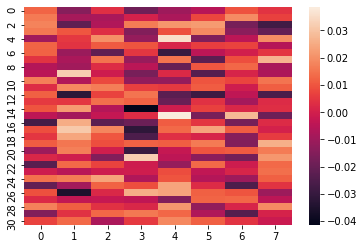



Experiment 1: target state = [-0.382-0.288j  0.004+0.483j  0.011+0.031j  0.733-0.j   ]
0.9092629943198581
Custom gates approximate state: [-0.346-0.33j   0.073+0.566j -0.082-0.173j  0.616+0.173j]
Google approximate state: [-0.346-0.33j   0.073+0.566j -0.082-0.173j  0.616+0.173j]
Target state: [-0.382-0.288j  0.004+0.483j  0.011+0.031j  0.733-0.j   ]
Fidelity score: 0.9092629943198581

q0: ───Ry(π)───Ry(0.667π)───I───────I────────────I───────────Ry(0.333π)───Rz(0.333π)───I───────────Rx(0.5π)───I────────────Ry(π)───I───────Rx(0.25π)───Rx(0.25π)───Rx(0.25π)───I────────────I────────────I───────────I───────────Rz(0.667π)───Ry(0.333π)───I───────@───Rx(0.25π)───I────────────Rx(0.25π)───Rx(0.25π)───Rx(0.25π)───I────────────I────────────I────────────I───────────I───────────Ry(0.333π)───Ry(0.333π)───Rz(0.25π)───Ry(0.333π)───Rx(0.5π)───I───────────I────────────Ry(π)───Rx(0.25π)───Ry(0.667π)───I───────Rx(0.25π)───Rx(0.25π)───Rx(0.25π)───Rx(0.25π)───I────────────I────────────I────────────I───────

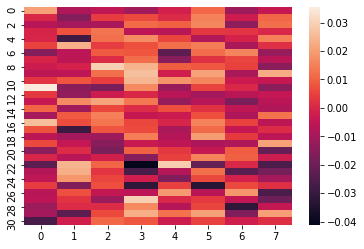



Experiment 2: target state = [0.462-0.191j 0.   +0.j    0.8  -0.331j 0.   +0.j   ]
Episode 0: inference completed in 4 steps. Fidelity score: 0.9330126585388477
Episode 1: inference completed in 2 steps. Fidelity score: 0.9829628666780088
Episode 2: inference completed in 4 steps. Fidelity score: 0.9633883017448203
Episode 3: inference completed in 8 steps. Fidelity score: 0.9171168423423472
Episode 7: inference completed in 1 steps. Fidelity score: 0.999999953533996
Episode 8: inference completed in 1 steps. Fidelity score: 0.999999953533996
Episode 9: inference completed in 1 steps. Fidelity score: 0.999999953533996
Episode 10: inference completed in 1 steps. Fidelity score: 0.999999953533996
Episode 11: inference completed in 1 steps. Fidelity score: 0.999999953533996
Episode 12: inference completed in 1 steps. Fidelity score: 0.999999953533996
Episode 13: inference completed in 1 steps. Fidelity score: 0.999999953533996
Episode 14: inference completed in 1 steps. Fidelity score: 

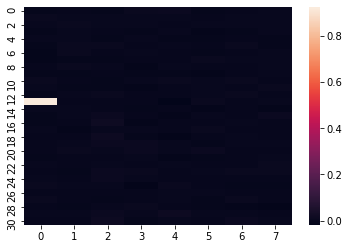



Experiment 3: target state = [-0.538-0.186j -0.701-0.243j  0.108+0.186j  0.14 +0.243j]
Episode 13: inference completed in 10 steps. Fidelity score: 0.922368641657603
Episode 19: inference completed in 5 steps. Fidelity score: 0.9026133558958511
Episode 20: inference completed in 6 steps. Fidelity score: 0.9026133558958511
Episode 44: inference completed in 19 steps. Fidelity score: 0.9112640598943659
Episode 51: inference completed in 16 steps. Fidelity score: 0.9506290607787775
Episode 52: inference completed in 19 steps. Fidelity score: 0.9181466378130159
Episode 54: inference completed in 19 steps. Fidelity score: 0.9405800824213316
Episode 60: inference completed in 13 steps. Fidelity score: 0.9341919096244888
Episode 62: inference completed in 9 steps. Fidelity score: 0.9026133900425275
Episode 63: inference completed in 9 steps. Fidelity score: 0.9026133900425275
Episode 65: inference completed in 19 steps. Fidelity score: 0.9147685134439727
Episode 72: inference completed in 1

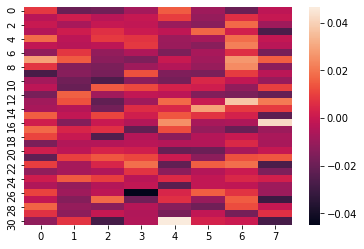



Experiment 4: target state = [-0.092+0.158j  0.683+0.j    -0.158-0.092j -0.   +0.683j]
Episode 28: inference completed in 13 steps. Fidelity score: 0.9173874438605164
Episode 47: inference completed in 8 steps. Fidelity score: 0.9239997118113752
Episode 53: inference completed in 11 steps. Fidelity score: 0.9171166224787928
Episode 60: inference completed in 3 steps. Fidelity score: 0.9330124363948826
Episode 64: inference completed in 10 steps. Fidelity score: 0.9202165693659596
Episode 65: inference completed in 10 steps. Fidelity score: 0.9202165693659596
Episode 66: inference completed in 18 steps. Fidelity score: 0.9393550839656999
Episode 68: inference completed in 10 steps. Fidelity score: 0.9202165693659596
Episode 70: inference completed in 3 steps. Fidelity score: 0.9330124363948826
Episode 71: inference completed in 15 steps. Fidelity score: 0.9173874438605157
Episode 72: inference completed in 17 steps. Fidelity score: 0.9330124363948822
Episode 77: inference completed in

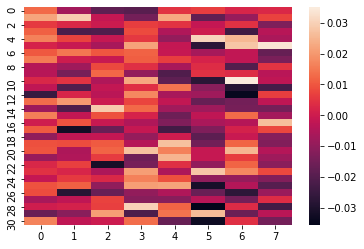



CPU times: user 2min 14s, sys: 6.98 s, total: 2min 21s
Wall time: 2min 11s


In [19]:
%%time
for i in range(NUM_EXPERIMENTS):
  start = [1, 0, 0, 0]
  target = get_quantum_state(TOLERANCE)

  print(f"Experiment {i}: target state = {np.around(target, 3)}")

  experiment = Experiment(start, target, TOLERANCE, TRAINING_EPISODES, STEP_SIZE, NUM_OFFLINE_UPDATES)
  gates_sequences, terminal_states = experiment.run_experiment()
  len_sequences = list(map(lambda x: len(x), gates_sequences))
  sns.heatmap(experiment._agent._W)
  
  idx = np.argmin(list(map(lambda x: len(x), gates_sequences)))
  circuit_gates = gates_sequences[idx]
  terminal_state = terminal_states[idx]
  target_state = QuantumState(target)

  print(target_state.fidelity_score(terminal_state))

  compare_circuits(circuit_gates, terminal_state, target_state)
  print("")

  plt.show()
  print("")
  print("")

# Analysis and TODO

Count the number of successes.
Some summary statistics of this type using binning should be plotted
In general this could be useful to compare different polcies
Please build a systematic set up

Compare 
- Step size decrease (che e un concettoesistente in Deep lr ==> scheduler): è migliorativo?
- behavioural policy: random o eps greedy?
- Different rewards
- Ragionare su perché il miglioramente non è costante, come invece vorrei,
==> ho bisogno di generalizzare? no devo essere di successo solo su cio che ho visto in training
Behaviour policy always exploring has been solution: try without.
Nota: la ragione del comportamento oscillante da episodio a episodio è dovuto al fatto che gradient descent rischia di cadere in local optima ==> rallenta la convergenza a una policy ottimale. Quanto invece ho dei buoni seed esco di lì. 
Devo mediare o cosa? Posso anche mediare, ma dire che a noi serve un global optimum per trovare l'optimal path, non generalizzare. Chiedo a tizio.

- Comparo diverse target policy da diversi behaviour!
- testare experience replay per capire al meglio ogni stato. ==> mi serve o posso togliere?
- Comparo numero di policy di successo rispetto a un approccio random: però la policy che imparo è imparata, il random no, cretino ==> quindi anche se e peggio in generale, basta sia buono una volta. Probabilmente il minimo che trovo è oslo locale, ma è gia sufficiente, e il fatto che ne esca continuamente richiede soluzione a piu ampio spettro a cui non sono interessato ora

Run an inference every N episodes and monitor the optimality of the behaviour
We could add experience replay, since after a certain number of new episodes it doesn't work well anymore